**CREATION OF AN AUTOMATED SPAM DETECTION MODEL**

In [1]:
# Importing necessary libraries
# Aspects of NLP shall be used hence we import required NLP libraries as well
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# setting the visuals to be more appealing to the eye that the generic sns
sns.set()
import wordcloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import warnings # To ignore the warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Loading the dataset
url = 'https://raw.githubusercontent.com/priyalagarwal27/E-mail-spam-detection/main/messages.csv'
df = pd.read_csv(url)

In [3]:
# Viewing the df
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [4]:
# Getting the shape (size) of the df
print("Shape of the dataset is:",df.shape)

Shape of the dataset is: (2893, 3)


**Observation:** The df has 2893 observations and 3 features

In [5]:
# Checking the data types of the feature
df.dtypes

subject    object
message    object
label       int64
dtype: object

**Observation:** 2 features have object data types while 1 feature has an integer data type

**Data Preprocessing**

In [6]:
 # Viewing statistical details from the df
df.describe(include='all')

,subject,message,label
count,2831,2893,2893.000000
unique,2613,2859,NaN
top,sociolinguistics,this is not spam ; you are receiving this mess...,NaN
freq,8,5,NaN
mean,NaN,NaN,0.166263
std,NaN,NaN,0.372381
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,0.000000


**Observations**
* "Subject" feature has 62 missing values.
* "Label" feature has 2 unique values, o and 1.

In [7]:
# checking for the sum of missing values in each variable
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

**Observation:** 
* Subject feature has 62 emails that dont have a subjecttied to the email observed from the statistical desc from the cell above.
* Missing subject does not affect our model building, hence no need to drop these observations




In [8]:
# Checking the number of spam and not spam emails in the dataset
print("Label counts:\n")
df['label'].value_counts()

Label counts:



0    2412
1     481
Name: label, dtype: int64

**Observation:** 
* 0 has a higher count than 1.
* 0 represents no spam, 1 represents spam

In [9]:
# Checking the ration/percentage of the label feature
print("Not a Spam Email Ratio (i.e., 0):",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email Ratio (i.e., 1):",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")

Not a Spam Email Ratio (i.e., 0): 83.0 %
Spam Email Ratio (i.e., 1): 17.0 %


**Observation:** Spam email compromise 17% whereas not spam compromise 83% of the labels.

In [10]:
# Creating a new feature called "length" to store length of each message
df['length'] = df.message.str.len()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


**Observation:**
* New feature, length, created.
* Lengths of each message is stored under new feaature.

**Further cleaning of the dataset using NLP features**




In [11]:
# Converting all messages to lower case
df['message'] = df['message'].str.lower()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


**Observation:** 
* all content under the message feature has been converted to lower case.

In [12]:
# Regular Expressions
# Replacing email addresses
# Remove spacing between special characters in email addresses
df['message'] = df['message'].str.replace(r"(\s(?=[\*/\\$&+,:;=?!@#|\"'<>.^()\[\]\{\}_-])|(?<=[\*/\\$&+,:;=?!@#|\"'<>.^()\[\]\{\}_-])\s)", '')

# Replace email addresses with 'emailaddress'
df['message'] = df['message'].str.replace(r'([a-z0-9+\{\}.,_-]+@[a-z0-9._-]+\.[a-z0-9_-]+)',' emailaddress')

In [13]:
# RegEx
# Replace web addresses
# Replace web addresses beginning with http:// or https://
df['message'] = df['message'].str.replace(r'(http:\/\/|https:\/\/|http\/\/|http:\/|http=:\/\/|http:\\\\)[a-z0-9\*/\\$&+%,:;=?!@#|\"\'<>.^()\[\]_-]+', ' webaddress')

# Replace other web addresses
df['message'] = df['message'].str.replace(r'(www\.|ftp:\/\/|ftp\/\/|ftp\.|html:\/\/)[a-z0-9\*/\\$&+%,:;=?!@#|\"\'<>.^()\[\]_-]+', ' webaddress')
df['message'] = df['message'].str.replace(r'[a-z0-9.]+(?=\.ac\.uk)+(\.ac\.uk)', ' webaddress')

In [14]:
# RegEx
# Replace currency symbols
# Currency symbols found in the dataset: us$, nt$, aus$, $, $ (amount) usd, usd
df['message'] = df['message'].str.replace(r'(us\$|nt\$|aus\$|\$| usd | usd+|usd_|_usd\/dm\/gbp|gbp)', ' moneysymb ')
df['message'] = df['message'].str.replace(r'(?<=\d) +(usd)', ' moneysymb ')
df['message'] = df['message'].str.replace(r'(usd )+(?=\d)', ' moneysymb ')
df['message'] = df['message'].str.replace(r'((?<=\d)\.-usd|(?<=\d),-usd)', ' moneysymb ')

In [15]:
# RegEx
# Replace phone numbers
# Phone numbers appear to be 8-13 digits long and include international phone numbers
df['message'] = df['message'].str.replace(r'(\+?\(? *?\/?[\d]\)?-*? *?\/?){14}',' phonenumber')
df['message'] = df['message'].str.replace(r'(\+?\(? *?\/?[\d]\)?-*? *?\/?){13}',' phonenumber')
df['message'] = df['message'].str.replace(r'(\+?\(? *?\/?[\d]\)?-*? *?\/?){12}',' phonenumber')
df['message'] = df['message'].str.replace(r'(\+?\(? *?\/?[\d]\)?-*? *?\/?){11}',' phonenumber')
df['message'] = df['message'].str.replace(r'(\+?\(? *?\/?[\d]\)?-*? *?\/?){10}',' phonenumber')
df['message'] = df['message'].str.replace(r'(\+?\(? *?\/?[\d]\)?-*? *?\/?){9}',' phonenumber')
df['message'] = df['message'].str.replace(r'(\+?\(? *?\/?[\d]\)?-*? *?\/?){8}',' phonenumber')

In [16]:
# Replace numeric characters
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', ' numbr ')

In [17]:
# Remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'(^\s|\s$)', '')

In [ ]:
# from google.colab import files
# df.to_csv('mails.csv') 
# files.download('mails.csv')


In [18]:
# Viewing the cleaned dataset
df.head(3)

,subject,message,label,length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856
1,NaN,lang classification grimes joseph e and barbar...,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas em...,0,1435


**Observations**
* email addresses, URLs, 10 digit phone numbers, currency symbols, whitespace between terms with a single space and numeric characters have been replaced.
* Punctuation marks together with leading and trailing whitespace have been removed.

In [19]:
# Removing stopwords
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [20]:
# New column (cleaned_length) after puncuations,stopwords removal
df['cleaned_length'] = df.message.str.len()
df.head()

,subject,message,label,length,cleaned_length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856,2093
1,NaN,lang classification grimes joseph e barbara f ...,0,1800,1376
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas emailaddress res...,0,1435,989
3,risk,colleague researching differing degrees risk p...,0,324,210
4,request book information,earlier morning phone friend mine living south...,0,1046,613


In [21]:
# Checking the length of the original messages and the cleaned messages
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.cleaned_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.cleaned_length.sum()))

Original Length: 9344743
Cleaned Length: 6527053
Total Words Removed: 2817690


**Observation**
* Original length of messages is higher than the length of cleaned messages.
* The number of total words removed is in excess of over 2.5 million

**EDA**

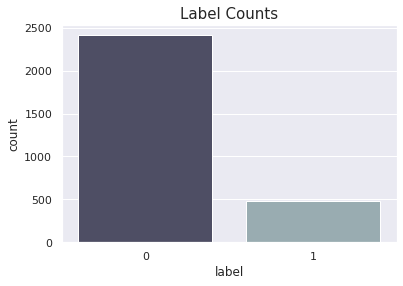

Actual number of labels:
 0    2412
1     481
Name: label, dtype: int64


In [22]:
# Graphical Visualisation 
# Visualizing number of labels.

plt.figure(figsize=(6,4))
sns.countplot(df['label'], palette= 'bone')
plt.title("Label Counts",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

print("Actual number of labels:\n",df.label.value_counts())

**Observation:**
* There is a significant class imbalance in the target variable

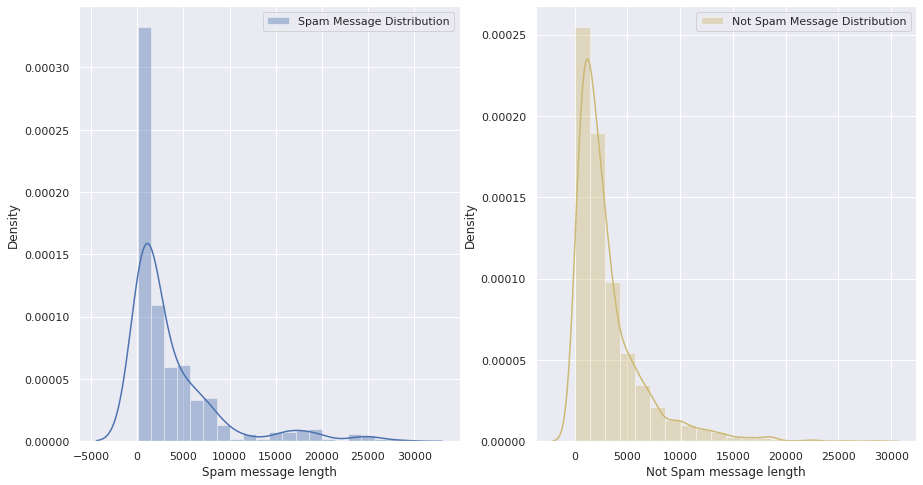

In [23]:
# Message distribution before cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='b')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='y')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

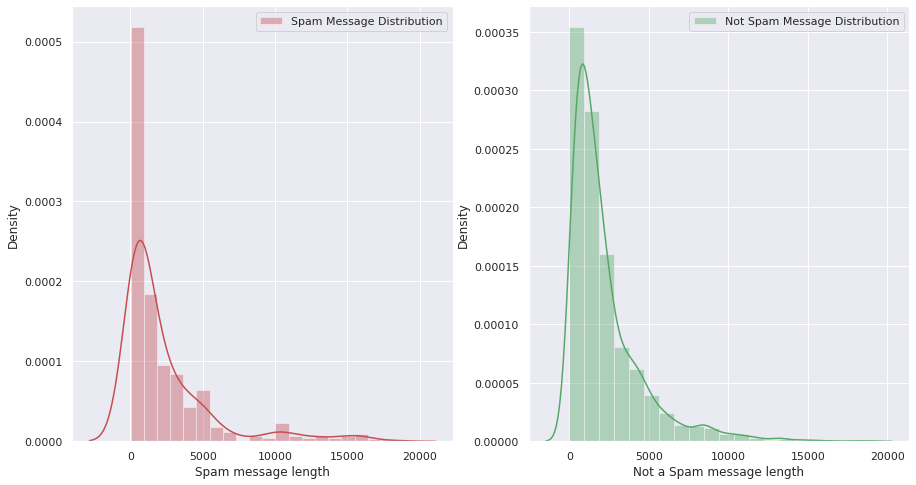

In [24]:
# Message distribution after cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['cleaned_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['cleaned_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

**Observation**
* Spam messages length distribution decreases after cleaning.
* Not spam messaages distribution increase after cleaning.

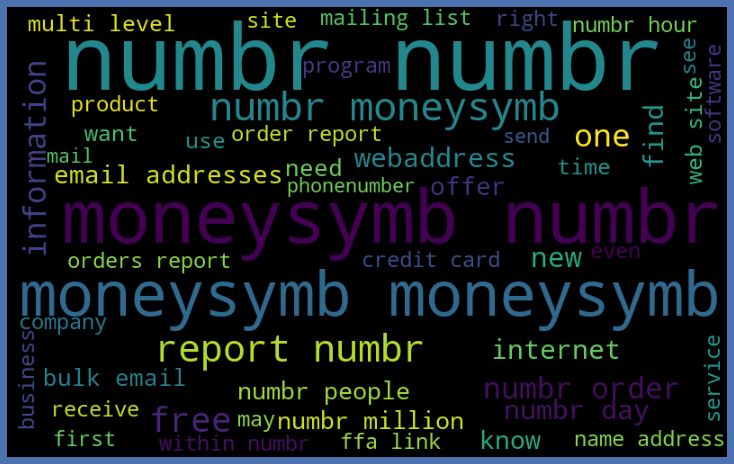

In [25]:
# Word Cloud
# Word cloud visualizes text data in which the size of each word indicates its frequesncy and importance 
# Getting sense of loud words in spam messages
from wordcloud import WordCloud
spams = df['message'][df['label']==1]
spam_cloud = WordCloud(width=800,height=500,background_color='black',max_words=50).generate(' '.join(spams))

# Visualizing the word cloud for spam messages
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

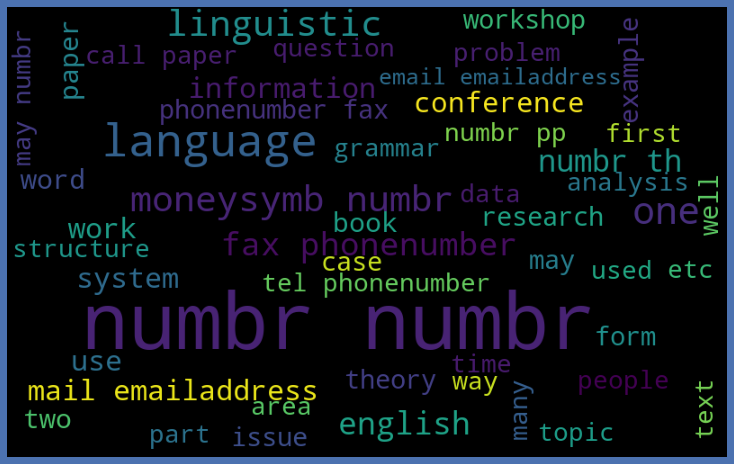

In [26]:
# Word Cloud 
# Getting sense of loud words in not-spam messages
from wordcloud import WordCloud
not_spams = df['message'][df['label']==0]
spam_cloud = WordCloud(width=800,height=500,background_color='black',max_words=50).generate(' '.join(not_spams))

# Visualizing non-spam messages with word cloud
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [27]:
# Text conversion into vectors
# TF-IDF is used for conversion
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Separating messages from labels
X = vectorizer.fit_transform(df['message']).toarray()
y = df['label']


In [28]:
# Splitting the dataset into Training and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

In [29]:
# Model 1: Naive Bayes

# Training the Naive Bayes Model on the Training Set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

GaussianNB(priors=None, var_smoothing=1e-09)

In [30]:
# Predicting the Test Result Test
y_pred = classifier.predict(X_test)
# print(y_pred)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [31]:
# Making the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

# Niave Bayes accuracy
print("Naive Bayes acuracy is:", accuracy_score(y_test, y_pred))

[[498   1]
 [ 16  64]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       499
           1       0.98      0.80      0.88        80

    accuracy                           0.97       579
   macro avg       0.98      0.90      0.93       579
weighted avg       0.97      0.97      0.97       579

Naive Bayes acuracy is: 0.9706390328151986


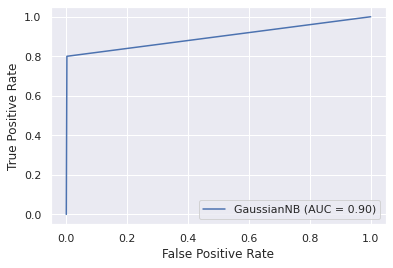

In [32]:
# Naive Bayes ROC/AUC Score
import matplotlib.pyplot as plt  
from sklearn import metrics

metrics.plot_roc_curve(classifier, X_test, y_test)  
plt.show()     

**Observation:** 
* AUC Score for Naive Bayes is 0.91. This shows the model is capable of distinguishing the classes well.

In [33]:
# Model 2: SVM
# The fit method of SVC class is called to train the algorithm on the training data which is passed as a parameter to the fit method.

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear') 
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
# Making Predictions
y_pred = svclassifier.predict(X_test)

In [35]:
# Evaluating the model with a confusion matrix 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))
print(cm)

# SVM accuracy
print("SVM Accuracy is:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       499
           1       0.99      0.94      0.96        80

    accuracy                           0.99       579
   macro avg       0.99      0.97      0.98       579
weighted avg       0.99      0.99      0.99       579

[[498   1]
 [  5  75]]
SVM Accuracy is: 0.9896373056994818


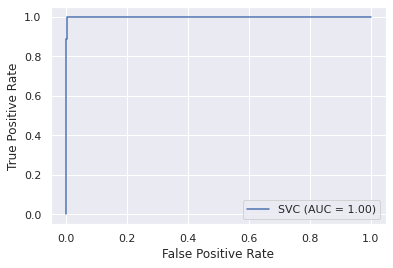

In [36]:
# SVM ROC/AUC Score
import matplotlib.pyplot as plt  
from sklearn import metrics

metrics.plot_roc_curve(svclassifier, X_test, y_test)  
plt.show()     

**Observation:** 
* SVMs AUC score is at a perfect score of 1

In [37]:
# Model 3: Random Forest
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [38]:
# Making Predictions and Evaluating the Model
predictions = text_classifier.predict(X_test)

In [39]:
# Evaluating the model with a confusion matrix 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[499   0]
 [  8  72]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       499
           1       1.00      0.90      0.95        80

    accuracy                           0.99       579
   macro avg       0.99      0.95      0.97       579
weighted avg       0.99      0.99      0.99       579

0.9861830742659758


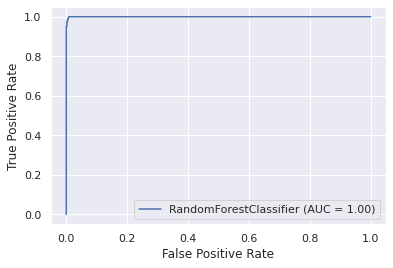

In [40]:
# Random Forest ROC/AUC Score
import matplotlib.pyplot as plt  
from sklearn import metrics

metrics.plot_roc_curve(text_classifier, X_test, y_test)  
plt.show()     

**Observation:**
* RF's AUC score is also at a perfect score of 1

**Saving the best performing model**


In [41]:
# SVM performs better than all other models

import pickle
filename = 'mail_spam_detector.pkl'
M=open(filename,'wb')
pickle.dump(SVC,M)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
M.close()